In [1]:
# -*- coding: utf-8 -*-
"""
Created on Tue Mar  7 17:52:41 2017

@author: Biagio Brattoli
"""
import numpy as np
import matplotlib.pyplot as plt
from time import time

import tensorflow as tf

/export/home/bbrattol/anaconda/envs/tensorflow_cpu/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
# Data
points_A = np.random.normal(loc=[1,1],scale=0.5,size=(600,2))
points_B = np.random.normal(loc=[3,3.5],scale=1.0,size=(600,2))
points_C = np.random.normal(loc=[0.5,3.5],scale=0.8,size=(600,2))

train_A = points_A[0:500,:]
test_A  = points_A[500:,:]
train_B = points_B[0:500,:]
test_B  = points_B[500:,:]
train_C = points_C[0:500,:]
test_C  = points_C[500:,:]

train_X = np.concatenate([train_A,train_B,train_C],axis=0)
train_y = np.concatenate([0*np.ones(train_A.shape[0]),
                          1*np.ones(train_B.shape[0]),
                          2*np.ones(train_C.shape[0])],axis=0)

test_X = np.concatenate([test_A,test_B,test_C],axis=0)
test_y = np.concatenate([0*np.ones(test_A.shape[0]),
                         1*np.ones(test_B.shape[0]),
                         2*np.ones(test_C.shape[0])],axis=0)


In [3]:
# Network definition
def rand_var(shape):
    return tf.truncated_normal(shape, stddev=0.01)

def const_var(shape):
    return tf.constant(0.1, shape=shape)

In [4]:
with tf.variable_scope('input'):
    x = tf.placeholder(tf.float32, (None,2), name='x')
    y = tf.placeholder(tf.int64, (None,), name='y')

In [5]:
with tf.variable_scope('layer1'):
    h1_w = tf.Variable(rand_var((int(x.get_shape()[1]),64)), name='weight', trainable=True)
    h1_b = tf.Variable(const_var((64,)), name='bias', trainable=True)
    h1 = tf.add(tf.matmul(x,h1_w),h1_b, name='h1')

with tf.variable_scope('layer2'):
    h2_w = tf.Variable(rand_var((int(h1.get_shape()[1]),32)), name='weight', trainable=True)
    h2_b = tf.Variable(const_var((32,)), name='bias', trainable=True)
    h2 = tf.add(tf.matmul(h1,h2_w),h2_b, name='h2')

with tf.variable_scope('output'):
    out_w = tf.Variable(rand_var((int(h2.get_shape()[1]),3)), name='weight', trainable=True)
    out_b = tf.Variable(const_var((3,)), name='bias', trainable=True)
    out = tf.add(tf.matmul(h2,out_w),out_b, name='out')
    prob = tf.nn.softmax(out, name='prob')

In [6]:
graph = tf.get_default_graph()
config = tf.ConfigProto(log_device_placement=False,
                        allow_soft_placement=True)
config.gpu_options.per_process_gpu_memory_fraction = 0.3

sess = tf.Session(config=config)

In [7]:
# Loss definition
pred = tf.argmax(prob, dimension=1)

cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=out,labels=y)
cost = tf.reduce_mean(cross_entropy)
train_op = tf.train.AdagradOptimizer(learning_rate=1e-2).minimize(cost)

correct_prediction = tf.equal(pred,tf.cast(y,tf.int64))
accuracy = tf.reduce_mean(tf.cast(correct_prediction,tf.float32))

sess.run(tf.global_variables_initializer())

In [8]:
# Train
N = train_X.shape[0]
batch_size = 100
B = N/batch_size

p = np.random.permutation(N)
train_X = train_X[p,:]
train_y = train_y[p]

In [9]:
# Training loop
for ii in xrange(2000):
    t1 = time()
    batch_idx = ii%B
    feed_dict_train = {x: train_X[batch_size*batch_idx:batch_size*(batch_idx+1)],
                       y: train_y[batch_size*batch_idx:batch_size*(batch_idx+1)]}
    
    _,acc,loss = sess.run([train_op,accuracy,cost], feed_dict=feed_dict_train)
    if ii%50==0:
        print 'Iter %d, Loss=%.3f, Train Accuracy= %.3f done in %.3f'%(ii,loss,acc,time()-t1)

Iter 0, Loss=1.098, Train Accuracy= 0.390 done in 0.010
Iter 50, Loss=1.099, Train Accuracy= 0.300 done in 0.001
Iter 100, Loss=1.098, Train Accuracy= 0.340 done in 0.001
Iter 150, Loss=1.099, Train Accuracy= 0.570 done in 0.001
Iter 200, Loss=1.099, Train Accuracy= 0.300 done in 0.001
Iter 250, Loss=1.098, Train Accuracy= 0.340 done in 0.001
Iter 300, Loss=1.098, Train Accuracy= 0.300 done in 0.001
Iter 350, Loss=1.098, Train Accuracy= 0.440 done in 0.001
Iter 400, Loss=1.098, Train Accuracy= 0.750 done in 0.001
Iter 450, Loss=1.098, Train Accuracy= 0.470 done in 0.001
Iter 500, Loss=1.097, Train Accuracy= 0.610 done in 0.001
Iter 550, Loss=1.096, Train Accuracy= 0.660 done in 0.001
Iter 600, Loss=1.094, Train Accuracy= 0.760 done in 0.001
Iter 650, Loss=1.090, Train Accuracy= 0.480 done in 0.001
Iter 700, Loss=1.077, Train Accuracy= 0.460 done in 0.001
Iter 750, Loss=1.038, Train Accuracy= 0.480 done in 0.001
Iter 800, Loss=0.995, Train Accuracy= 0.440 done in 0.001
Iter 850, Loss=0.

In [10]:
# Test
feed_dict_test = {x: test_X, y: test_y}
acc,loss = sess.run([accuracy,cost], feed_dict=feed_dict_test)

print 'Test Loss=%.3f, Test Accuracy= %.3f'%(loss,acc)

Test Loss=0.209, Test Accuracy= 0.913


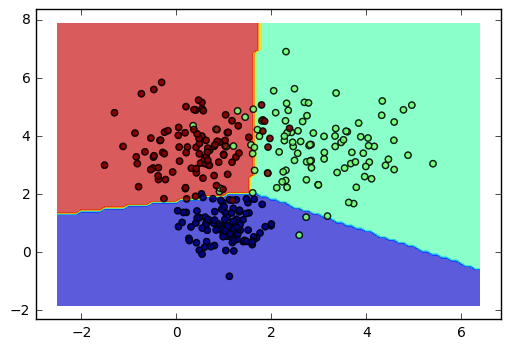

In [12]:
# Plotting decision regions
x_min, x_max = test_X[:, 0].min() - 1, test_X[:, 0].max() + 1
y_min, y_max = test_X[:, 1].min() - 1, test_X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

#f, axarr = plt.subplots(1,1, sharex='col', sharey='row', figsize=(10, 8))

feed_dict = {x: np.c_[xx.ravel(), yy.ravel()]}
Z = sess.run(pred, feed_dict=feed_dict)
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.4)
plt.scatter(test_X[:, 0], test_X[:, 1], c=test_y, alpha=0.8)
#plt.set_title('Decision boundaries')

plt.show()